In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, brier_score_loss, classification_report,roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_sample_weight

In [41]:
df = pd.read_csv("/Users/hrishityelchuri/Desktop/github/grabhack/driver-credit-scoring-engine/data/processed/df_feature_engineered.csv")

In [42]:
print(df.columns)

Index(['partner_id', 'role', 'gender', 'age_group', 'city_tier',
       'earnings_avg', 'on_time_rate', 'cancel_rate', 'customer_rating',
       'complaints', 'accidents', 'night_shift_pct', 'cashless_ratio',
       'past_due_history', 'good_repayment', 'vehicle_age_bin', 'earnings_cv',
       'productivity_stability', 'earnings_stability', 'wallet_txn_bin',
       'tenure_x_earnings', 'active_x_reliability', 'engagement_ratio',
       'weekly_trip_ratio', 'reliability_index', 'complaint_rate',
       'accident_rate', 'txn_freq_per_day', 'wallet_txn_flag',
       'vehicle_utilization', 'earnings_vs_city_avg', 'rating_vs_age_avg'],
      dtype='object')


In [43]:
categorical_features = ["role", "gender", "age_group", "city_tier", 
                        "vehicle_age_bin", "wallet_txn_bin"]
numeric_features = [col for col in df.columns if col not in categorical_features + ["good_repayment"]]

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ]
)

In [45]:
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",   # handles imbalance
        random_state=42
    ))
])

In [46]:
drop_cols = ["good_repayment"]  # only drop target

X = df.drop(columns=drop_cols)
y = df["good_repayment"]


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [48]:
def reweight_samples(df, sensitive_col="city_tier"):
    group_counts = df[sensitive_col].value_counts()
    weights = df[sensitive_col].map(lambda x: 1.0 / group_counts[x])
    return (weights / weights.mean()).values

w_train = reweight_samples(X_train, sensitive_col="city_tier")

In [49]:
clf.fit(X_train, y_train, classifier__sample_weight=w_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [50]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.95      1.00      0.97      1514

    accuracy                           0.95      1600
   macro avg       0.47      0.50      0.49      1600
weighted avg       0.90      0.95      0.92      1600



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

In [51]:
y_prob = clf.predict_proba(X_test)[:, 1]

In [52]:
# 1. AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc:.3f}")

# 2. KS Statistic
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
ks_stat = max(tpr - fpr)
print(f"KS Statistic: {ks_stat:.3f}")

# 3. Gini Coefficient
gini = 2 * auc - 1
print(f"Gini Coefficient: {gini:.3f}")

# 4. Decile-wise lift analysis
df_lift = pd.DataFrame({"y_true": y_test, "y_prob": y_prob})
df_lift["decile"] = pd.qcut(df_lift["y_prob"], 10, labels=False)

decile_summary = df_lift.groupby("decile").agg(
    total=("y_true", "count"),
    events=("y_true", "sum")
).sort_index(ascending=False)
decile_summary["event_rate"] = decile_summary["events"] / decile_summary["total"]
print("\nDecile-wise lift analysis:")
print(decile_summary)

AUC-ROC: 0.587
KS Statistic: 0.206
Gini Coefficient: 0.174

Decile-wise lift analysis:
        total  events  event_rate
decile                           
9         103     100    0.970874
8         159     149    0.937107
7          99      93    0.939394
6         246     236    0.959350
5          91      90    0.989011
4         218     211    0.967890
3         169     163    0.964497
2         150     143    0.953333
1         192     169    0.880208
0         173     160    0.924855


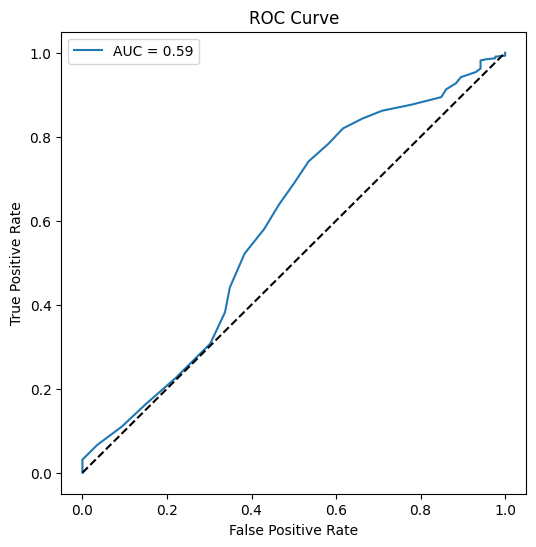

In [53]:
#Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

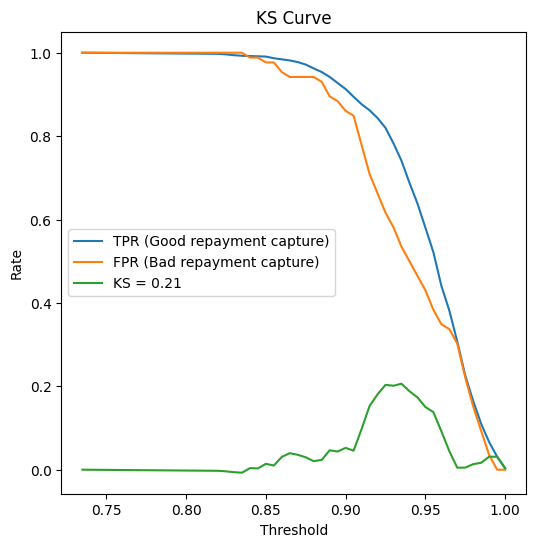

In [54]:
# Plot KS curve
plt.figure(figsize=(6,6))
plt.plot(thresholds, tpr, label="TPR (Good repayment capture)")
plt.plot(thresholds, fpr, label="FPR (Bad repayment capture)")
plt.plot(thresholds, tpr - fpr, label=f"KS = {ks_stat:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("KS Curve")
plt.legend()
plt.show()